1. The platform is built using ```NetworkX``` and ```cugraph```.

2. The part of platform code is from my social network course homework and thus is not allowed to publish in public. Please contact me if you are interested.

3. This notebook only showcases the functionality of the platform. Detailed analysis of the actors social network is not the main focus of this notebook. 



4. Some of the functions are accelerated using GPU.

In [2]:
!nvidia-smi

Fri May 28 06:14:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os, shutil

sys.path.append('/usr/local/lib/python3.7/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ["CONDA_PREFIX"] = "/usr/local"
for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
  fn = 'lib'+so+'.so'
  source_fn = '/usr/local/lib/'+fn
  dest_fn = '/usr/lib/'+fn
  if os.path.exists(source_fn):
    print(f'Copying {source_fn} to {dest_fn}')
    shutil.copyfile(source_fn, dest_fn)
# fix for BlazingSQL import issue
# ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/local/lib/python3.7/site-packages/../../libblazingsql-engine.so)
if not os.path.exists('/usr/lib64'):
    os.makedirs('/usr/lib64')
for so_file in os.listdir('/usr/local/lib'):
  if 'libstdc' in so_file:
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

In [46]:
import pandas as pd
import numpy as np
import networkx as nx

from itertools import combinations
from tqdm import tqdm
from SNAplatform import SNAplatform

# 1. Load data

In [58]:
with open('actor_ids.edgelist') as f: 
    vertices = set(map(int, f.read().split()))  

subgraph = vertices  # [0, 1, 0, 2, 0, ..

# 2. Instance the platform and plot the network

In [60]:
platform = SNAplatform('actor_ids.edgelist', vertices, subgraph, False)

## 2.1. Plot all nodes

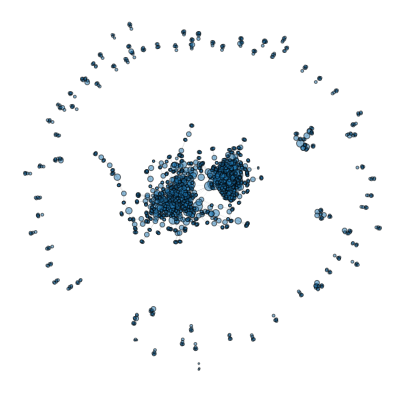

In [62]:
platform.plot_subgraph()

## 2.2. Plot the largest component

In [63]:
largest_component = platform.target.subgraph(max(nx.connected_components(platform.target), key=len))

In [64]:
platform_largest_component = SNAplatform('actor_ids.edgelist', vertices, largest_component, False)

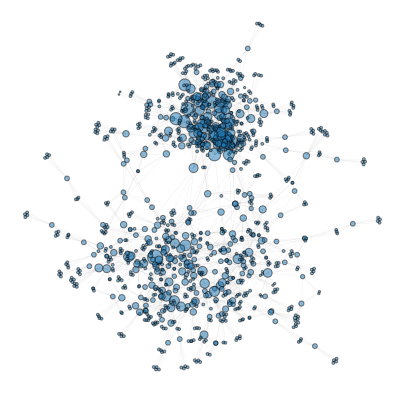

In [65]:
platform_largest_component.plot_subgraph()

# 3. Community dection with Girvan-Newman algorithm

100%|██████████| 300/300 [08:10<00:00,  1.63s/it]


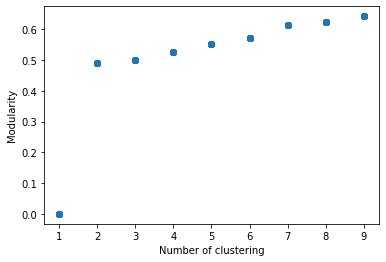

In [84]:
platform_largest_component.modularity_clustering_plot(300)

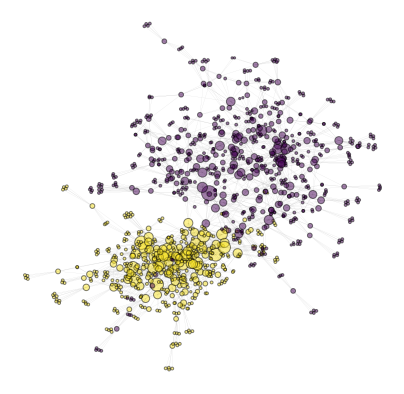

In [67]:
platform_largest_component.calculate_best_partition(2)

# 4. Split the network

In [70]:
platform_china = SNAplatform('actor_ids.edgelist', vertices, platform_largest_component.best_partition[0], False)
platform_us = SNAplatform('actor_ids.edgelist', vertices, platform_largest_component.best_partition[1], False)

# 5. Degree distribution in Chinese and the U.S. actors network

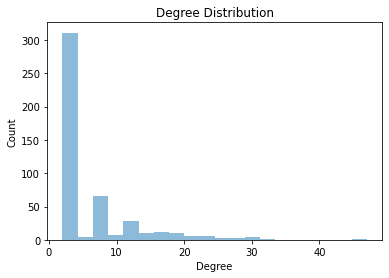

In [74]:
platform_china.degree_distribution()

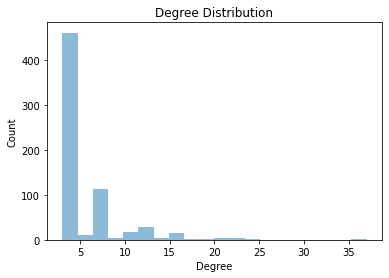

In [75]:
platform_us.degree_distribution()

# 6. Between distribution in Chinese and the U.S. actors network


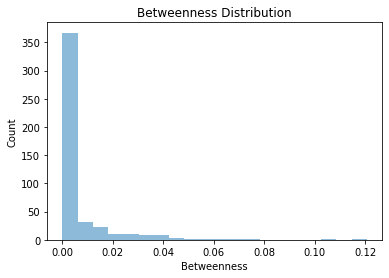

In [76]:
platform_china.betweenness_distribution()

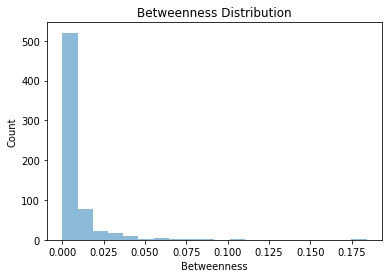

In [77]:
platform_us.betweenness_distribution()

# 7. Eigenvector distribution in Chinese and the U.S. actors network


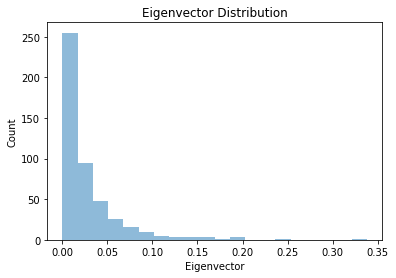

In [78]:
platform_china.eigenvector_distribution()

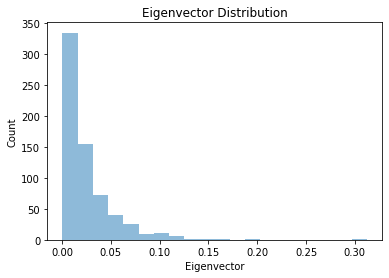

In [79]:
platform_us.eigenvector_distribution()

# 8. Local summary in Chinese and the U.S. actors network

In [80]:
platform_china.local_summary()

,Eigenvector,Betweenness,Closness,Clustering coefficient,Degree
count,470.00,470.00,470.00,470.00,470.00
mean,0.03,0.01,0.28,0.78,6.98
std,0.04,0.01,0.04,0.32,5.77
min,0.00,0.00,0.18,0.11,2.00
25%,0.01,0.00,0.25,0.43,4.00
50%,0.01,0.00,0.27,1.00,4.00
75%,0.03,0.00,0.30,1.00,8.00
max,0.34,0.12,0.40,1.00,47.00


In [81]:
platform_us.local_summary()

,Eigenvector,Betweenness,Closness,Clustering coefficient,Degree
count,662.00,662.00,662.00,662.00,662.00
mean,0.03,0.01,0.21,0.81,5.85
std,0.03,0.01,0.03,0.29,3.62
min,0.00,0.00,0.14,0.09,3.00
25%,0.01,0.00,0.19,0.43,4.00
50%,0.02,0.00,0.21,1.00,4.00
75%,0.03,0.01,0.23,1.00,8.00
max,0.31,0.18,0.30,1.00,37.00


# 9. Global summary in Chinese and the U.S. actors network

In [82]:
platform_china.global_summary()

,Global Summary
diameter of largest component,8.00
clustering coefficient,0.78
number of nodes,470.00
number of edges,1641.00
number of components,1.00
size largest component,470.00
number of isolates,0.00


In [83]:
platform_us.global_summary()

,Global Summary
diameter of largest component,10.00
clustering coefficient,0.81
number of nodes,662.00
number of edges,1935.00
number of components,1.00
size largest component,662.00
number of isolates,0.00
